<br><br>
<font size=6>Задание 1.</font>
<br><br>
<font size=4>Даны обращения клиентов в банк за 2018-2019гг.,<br> 
необходимо построить прогноз на первое полугодие 2020г.</font><br><br>
<hr>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error, mean_absolute_error
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.arima import ARIMA
from typing import Union

In [2]:
data = pd.read_excel('data/bank.xlsx', index_col=0).loc[:, "Обращения"]
data

Дата
2018-01-01     4177.0
2018-01-02     8375.0
2018-01-03    13324.0
2018-01-04    15566.0
2018-01-05    16257.0
               ...   
2020-06-26        NaN
2020-06-27        NaN
2020-06-28        NaN
2020-06-29        NaN
2020-06-30        NaN
Name: Обращения, Length: 912, dtype: float64

In [3]:
data.shape

(912,)

Данные для предсказания (первое полугодие 2020г):

In [4]:
data_test = data.loc['2020-01-01':]
data_test

Дата
2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
              ..
2020-06-26   NaN
2020-06-27   NaN
2020-06-28   NaN
2020-06-29   NaN
2020-06-30   NaN
Name: Обращения, Length: 182, dtype: float64

Тренировочные данные (2018-2019гг.)

In [5]:
data_train = data.loc[:'2019-12-31']
data_train

Дата
2018-01-01     4177.0
2018-01-02     8375.0
2018-01-03    13324.0
2018-01-04    15566.0
2018-01-05    16257.0
               ...   
2019-12-27    33269.0
2019-12-28    25353.0
2019-12-29    20426.0
2019-12-30    30094.0
2019-12-31    18006.0
Name: Обращения, Length: 730, dtype: float64

In [6]:
data_train.index = data_train.index.astype('Period[D]')

In [7]:
data_train

Дата
2018-01-01     4177.0
2018-01-02     8375.0
2018-01-03    13324.0
2018-01-04    15566.0
2018-01-05    16257.0
               ...   
2019-12-27    33269.0
2019-12-28    25353.0
2019-12-29    20426.0
2019-12-30    30094.0
2019-12-31    18006.0
Freq: D, Name: Обращения, Length: 730, dtype: float64

In [8]:
def get_distribution(*data: Union[pd.Series, list[pd.Series]], labels=None) -> None:
    """
    Функция для отрисовки графика распределения значений относительно времени
    :param data: данные для отрисовки
    """
    fig, ax = plt.subplots(figsize=(30, 8))
    plot_series(*data, labels=labels, ax=ax)
    plt.show()

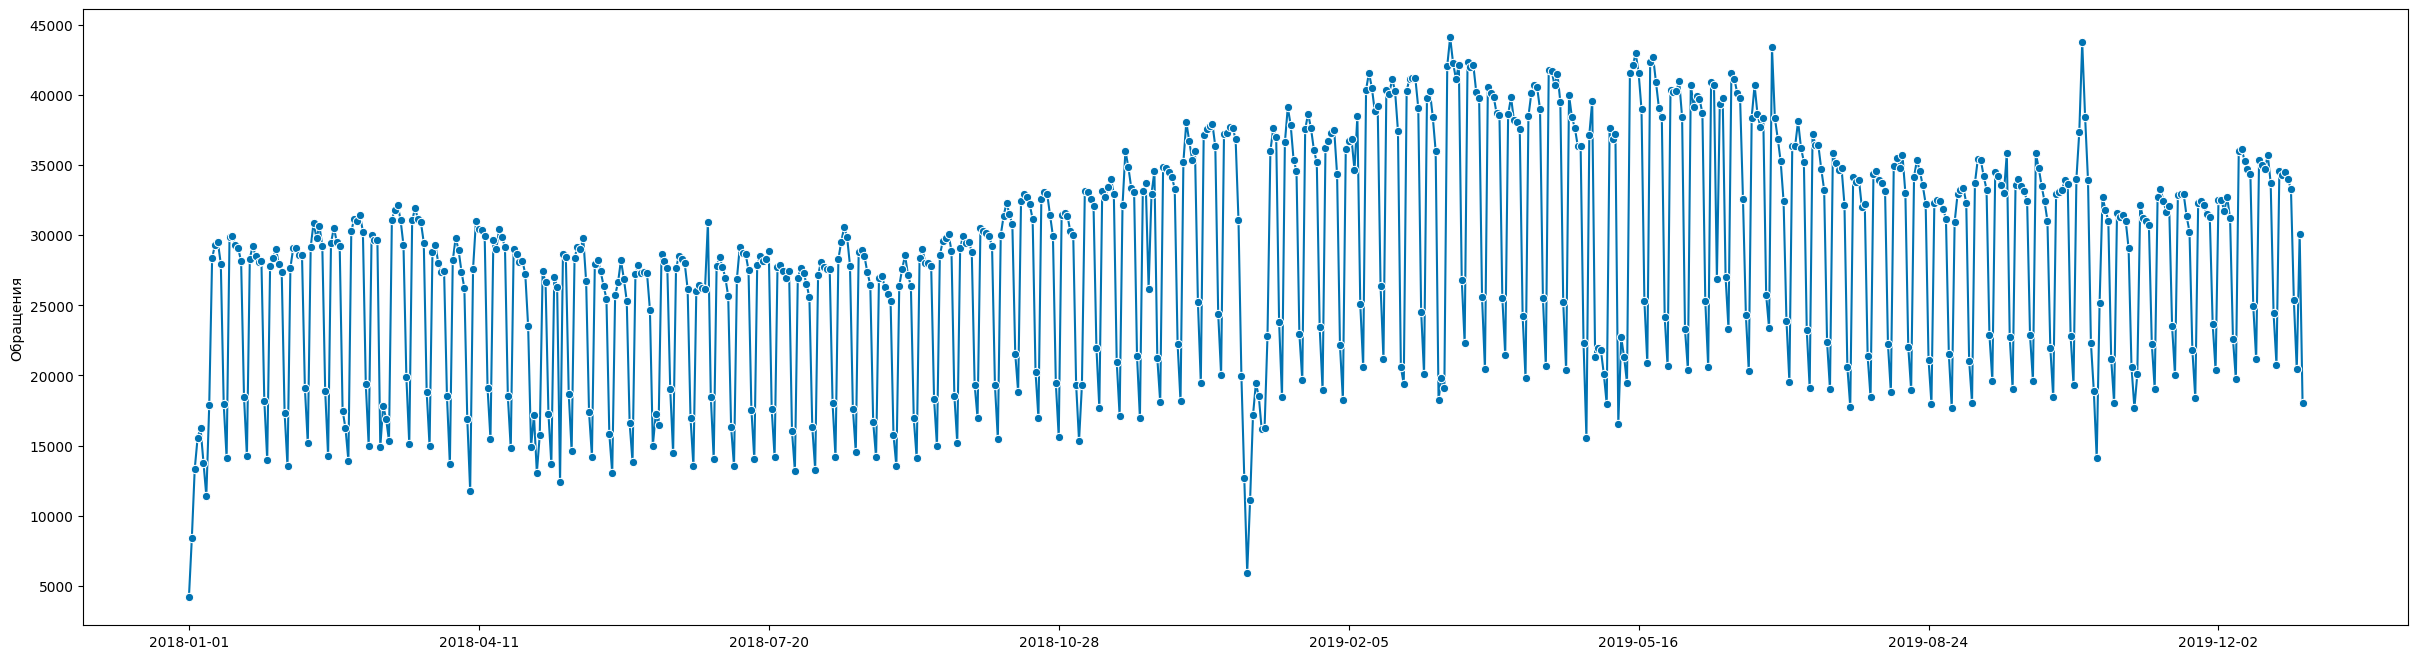

In [9]:
get_distribution(data_train)

<br>
Разделим data_train на train и test, чтобы протестировать модель<br>
<br>

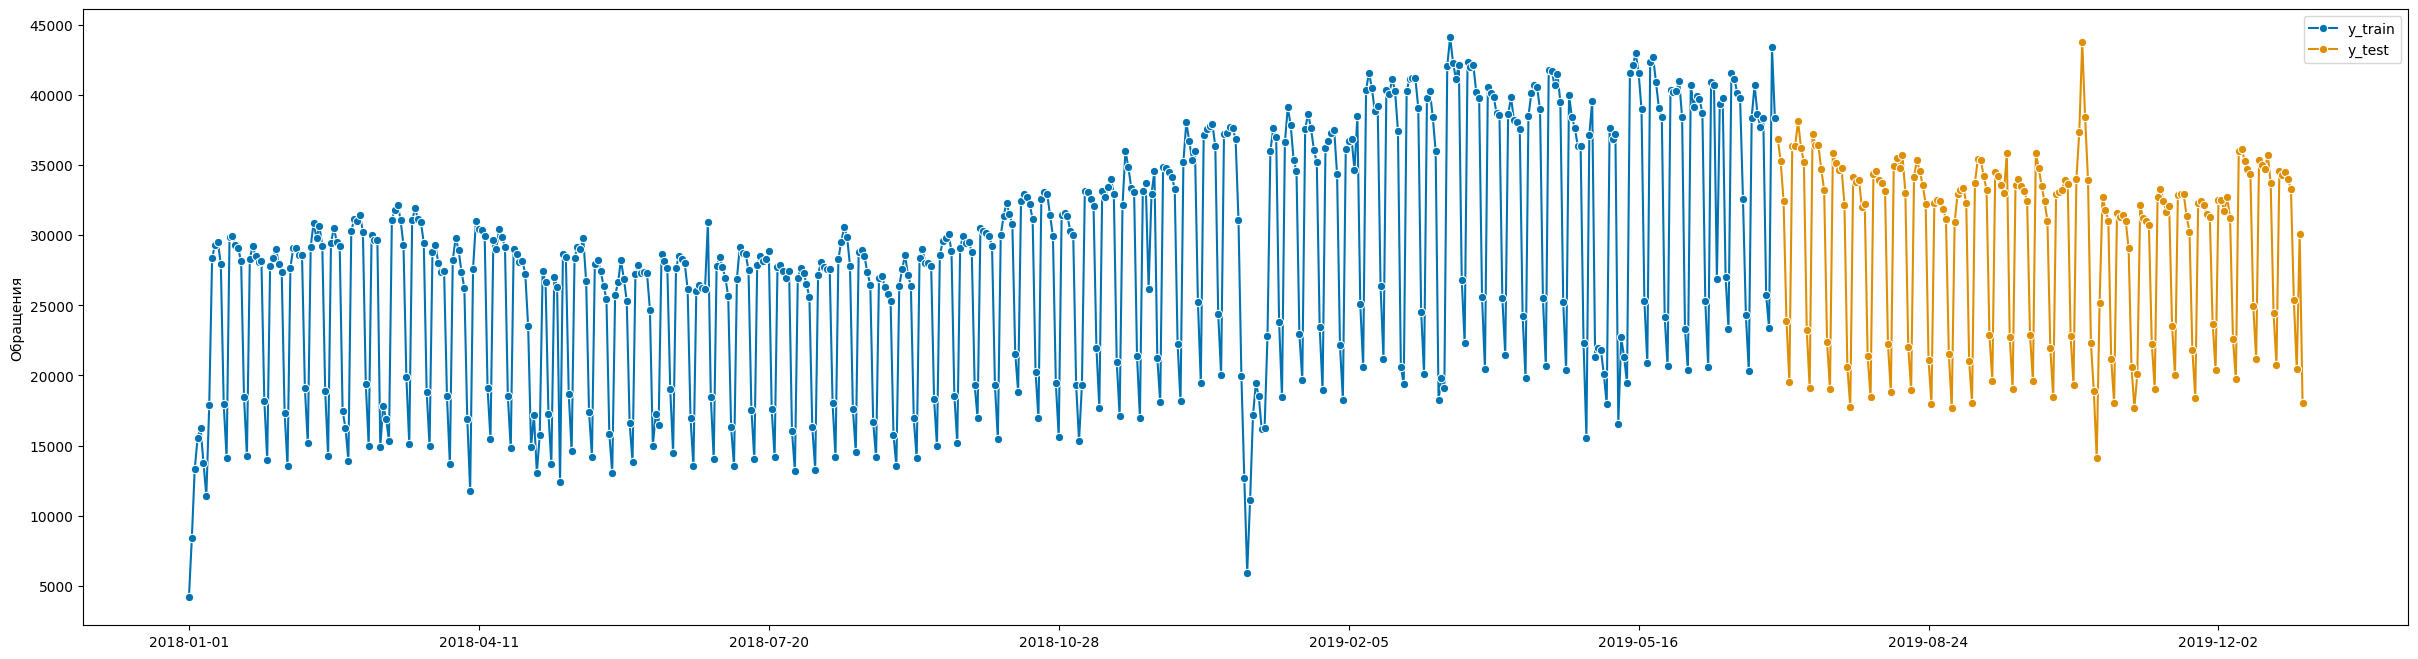

In [10]:
y_train, y_test = temporal_train_test_split(data_train, test_size=182)

get_distribution(y_train, y_test, labels=['y_train', 'y_test'])

<br>
<font size=4>ARIMA</font><br>
<br>

In [11]:
%%time
fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = ARIMA(order=(1, 0, 0), seasonal_order=(0, 1, 0, 182))
forecaster.fit(y_train)

CPU times: user 39.9 s, sys: 20.3 s, total: 1min
Wall time: 24 s


ARIMA(seasonal_order=(0, 1, 0, 182))

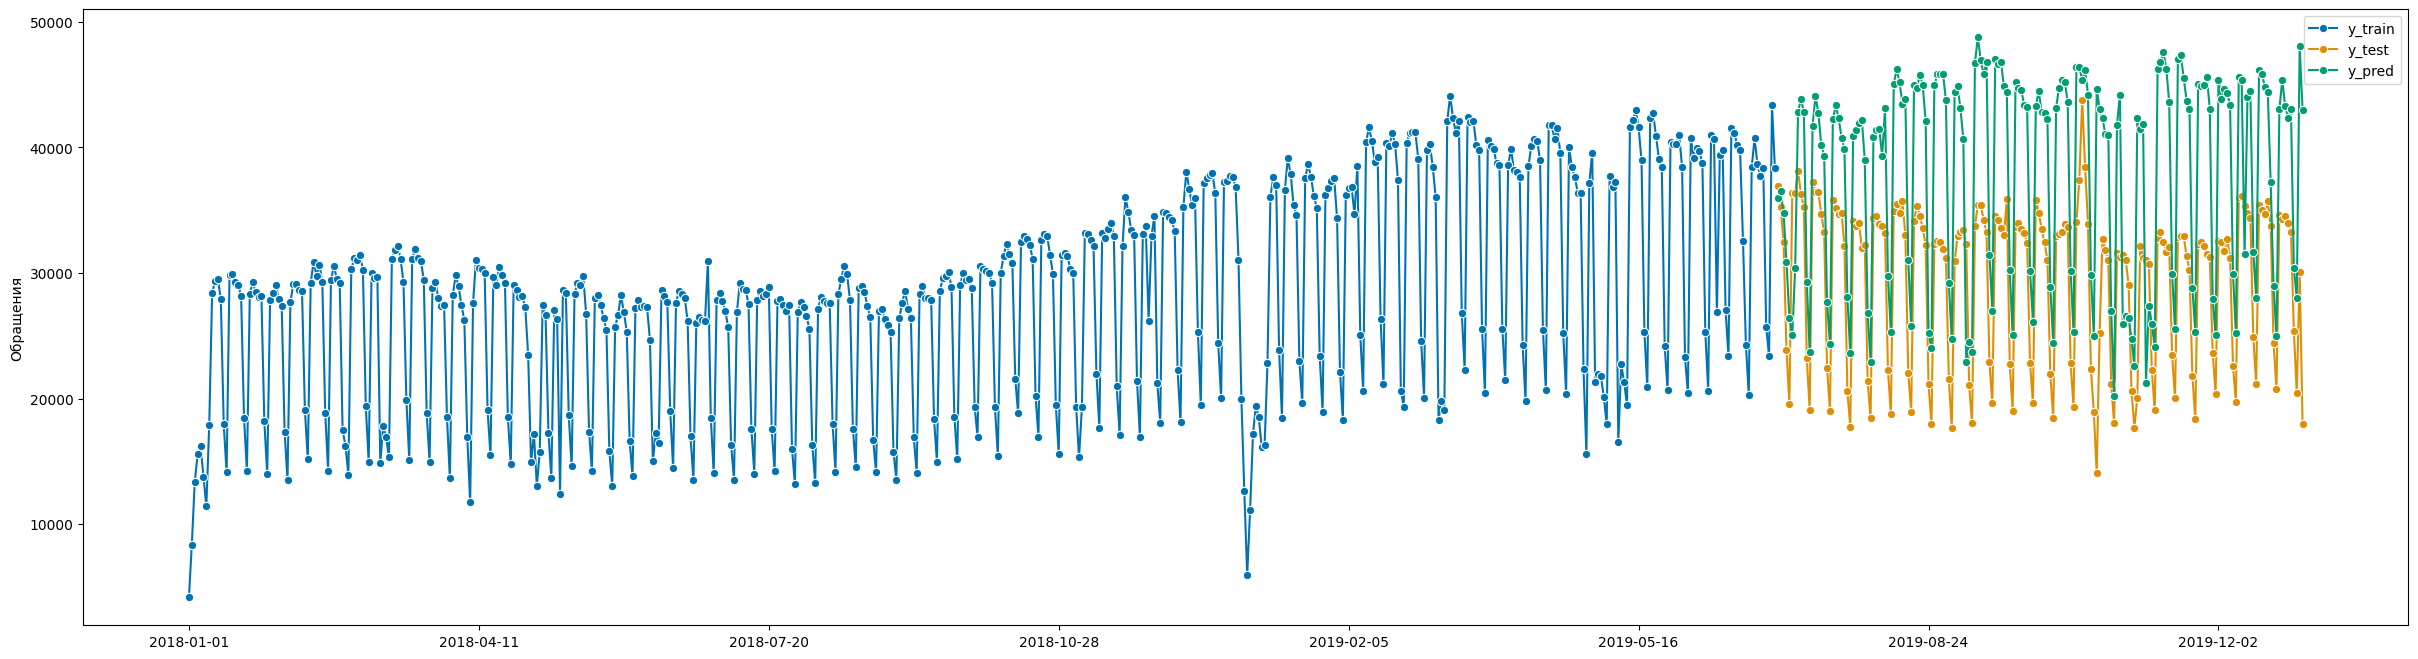

MAPE: 0.31554452774877234
MAE: 9004.513639849009


In [12]:
y_pred = forecaster.predict(fh)
get_distribution(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_pred, y_test)}')

<br>
<font size=4>DecisionTreeRegressor</font><br>
<br>

In [13]:
%%time
from sklearn.tree import DecisionTreeRegressor
from sktime.forecasting.compose import make_reduction

regressor = DecisionTreeRegressor(max_depth=5)
forecaster = make_reduction(regressor, strategy='recursive', window_length=365)
forecaster.fit(y_train)

CPU times: user 48.6 ms, sys: 11.8 ms, total: 60.4 ms
Wall time: 844 ms


RecursiveTabularRegressionForecaster(estimator=DecisionTreeRegressor(max_depth=5),
                                     window_length=365)

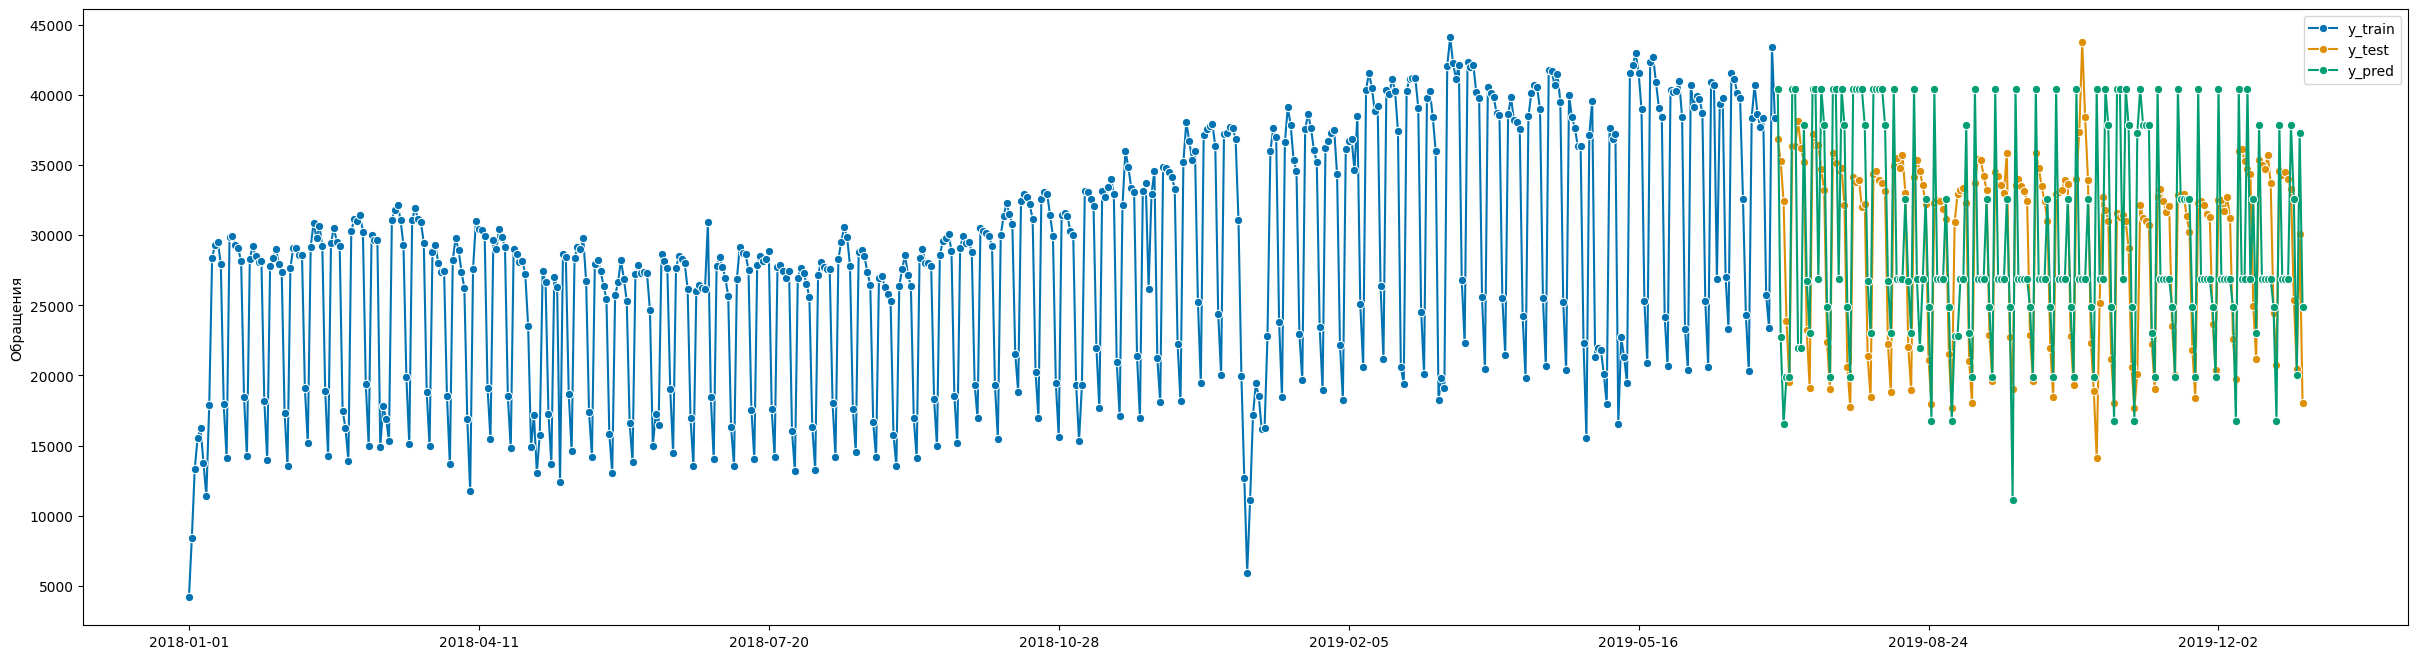

MAPE: 0.18424490553246978
MAE: 5480.286213252559


In [14]:
y_pred = forecaster.predict(fh)
get_distribution(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

<br>
<font size=4>RandomForestRegressor</font><br>
<br>

In [17]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

regressor = RandomForestRegressor(n_estimators=400, max_depth=10)
forecaster = make_reduction(regressor, strategy='recursive', window_length=365)
forecaster.fit(y_train)

CPU times: user 12 s, sys: 0 ns, total: 12 s
Wall time: 12.1 s


RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=10,
                                                                     n_estimators=400),
                                     window_length=365)

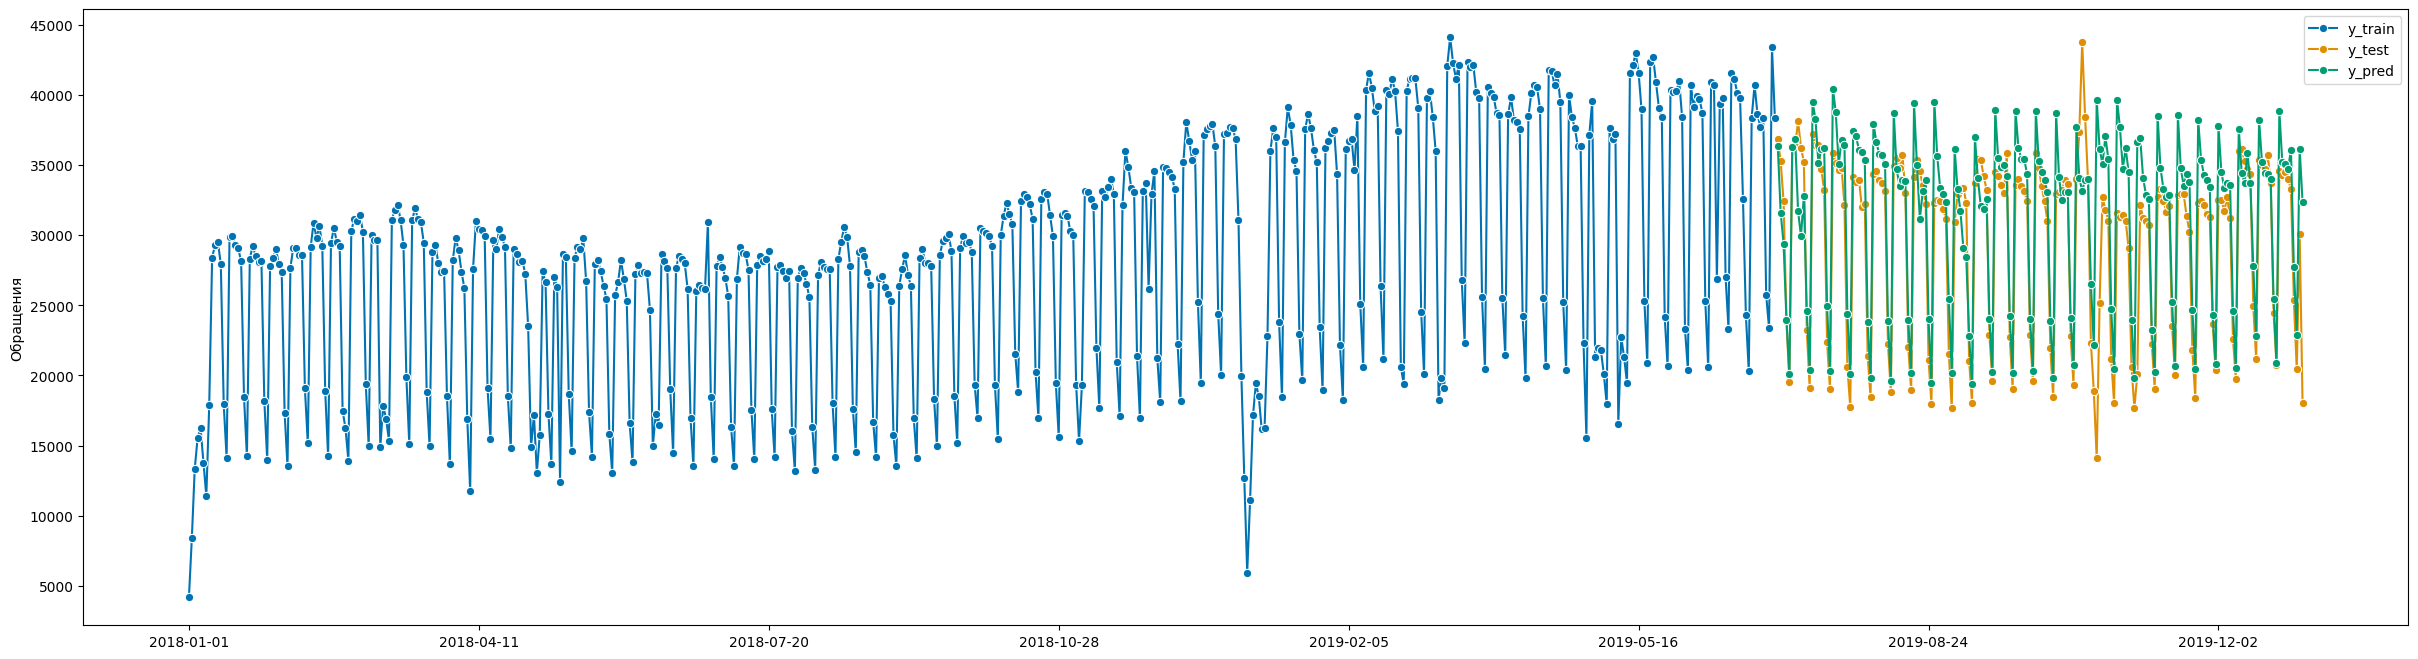

MAPE: 0.0996265069019373
MAE: 2681.0182437323506
Отношение среднего числа к ошибке: 10.573205247913812


In [18]:
y_pred = forecaster.predict(fh)
get_distribution(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])

print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'Отношение среднего числа к ошибке: {data_train.mean() / mean_absolute_error(y_test, y_pred)}')

<br>
<font size=4>Prediction</font>
<br><br>

In [22]:
data_test.index = data_test.index.astype('Period[D]')

In [23]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.compose import make_reduction

fh = ForecastingHorizon(data_test.index, is_relative=False)

regressor = RandomForestRegressor(n_estimators=400, max_depth=10)
forecaster = make_reduction(regressor, strategy='recursive', window_length=365)
forecaster.fit(data_train)

CPU times: user 24.9 s, sys: 0 ns, total: 24.9 s
Wall time: 24.9 s


RecursiveTabularRegressionForecaster(estimator=RandomForestRegressor(max_depth=10,
                                                                     n_estimators=400),
                                     window_length=365)

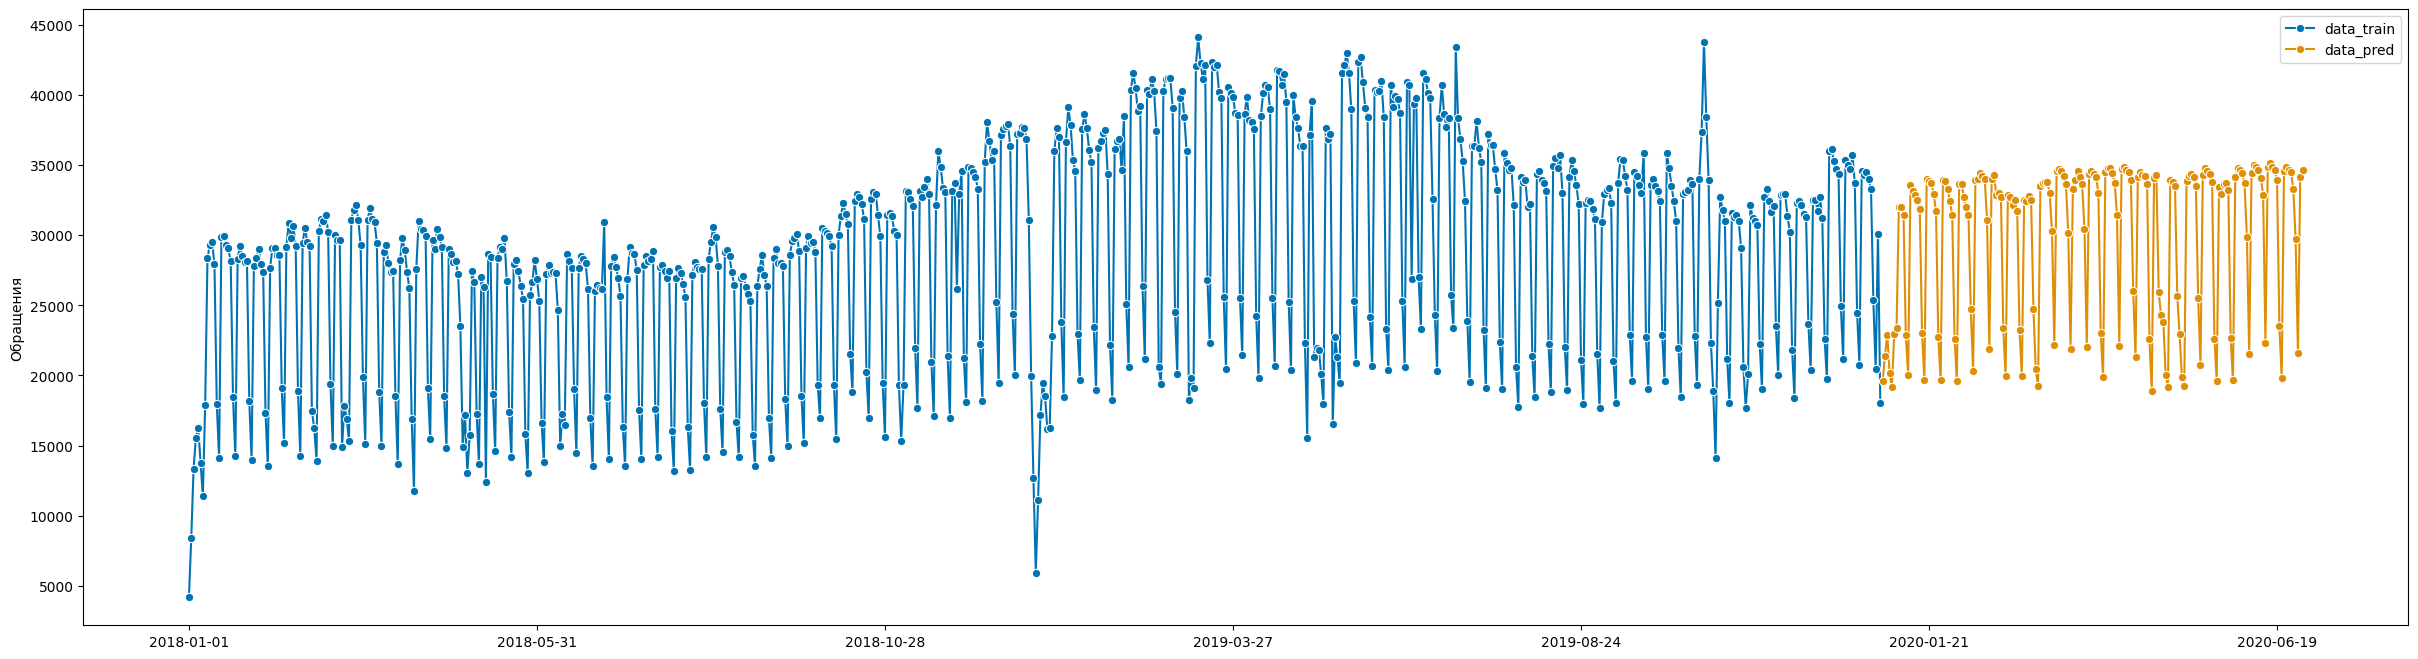

In [24]:
data_pred = forecaster.predict(fh)
get_distribution(data_train, data_pred, labels=['data_train', 'data_pred'])

<br>
<font size=4>Ответ к задаче:</font>
<br><br>

In [ ]:
data.loc['2020-01-01':] = data_pred.values
data = pd.DataFrame(data).reset_index()

In [57]:
data

,Дата,Обращения
0,2018-01-01,4177.000000
1,2018-01-02,8375.000000
2,2018-01-03,13324.000000
3,2018-01-04,15566.000000
4,2018-01-05,16257.000000
...,...,...
907,2020-06-26,33304.777923
908,2020-06-27,29730.033737
909,2020-06-28,21567.374824
910,2020-06-29,34137.014893


In [60]:
data['Дата'] = data['Дата'].astype('Period[D]')

In [63]:
data

,Дата,Обращения
0,2018-01-01,4177.000000
1,2018-01-02,8375.000000
2,2018-01-03,13324.000000
3,2018-01-04,15566.000000
4,2018-01-05,16257.000000
...,...,...
907,2020-06-26,33304.777923
908,2020-06-27,29730.033737
909,2020-06-28,21567.374824
910,2020-06-29,34137.014893


In [30]:
data.to_excel('Обращения.xlsx')

<br><br>
<font size=6>Задание 2.</font>
<br><br>
<font size=4>Дан объём ЗП исходя из стажа сотрудника, необходимо спрогнозировать ЗП при стаже 5 лет.</font><br><br>
<hr>

In [486]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore')

In [487]:
data = pd.read_excel('data/salary.xlsx').iloc[:, :2]
data.columns = ["Стаж", 'ЗП']
data

,Стаж,ЗП
0,0.0,14.41
1,0.3,12.24
2,0.5,14.43
3,0.8,14.88
4,1.1,16.29
5,1.3,20.20
6,1.6,19.04
7,1.8,23.50
8,2.1,23.35
9,2.4,24.61


In [488]:
data_train = data.drop(16) # тренировочные данные
data_test = data.iloc[-1:, :] # данные для предсказания
print(f'{data_train} \n\n {data_test}')

    Стаж     ЗП
0    0.0  14.41
1    0.3  12.24
2    0.5  14.43
3    0.8  14.88
4    1.1  16.29
5    1.3  20.20
6    1.6  19.04
7    1.8  23.50
8    2.1  23.35
9    2.4  24.61
10   2.6  28.61
11   2.9  28.58
12   3.2  30.93
13   3.4  33.52
14   3.7  38.81
15   3.9  42.88 

     Стаж  ЗП
16   5.0 NaN


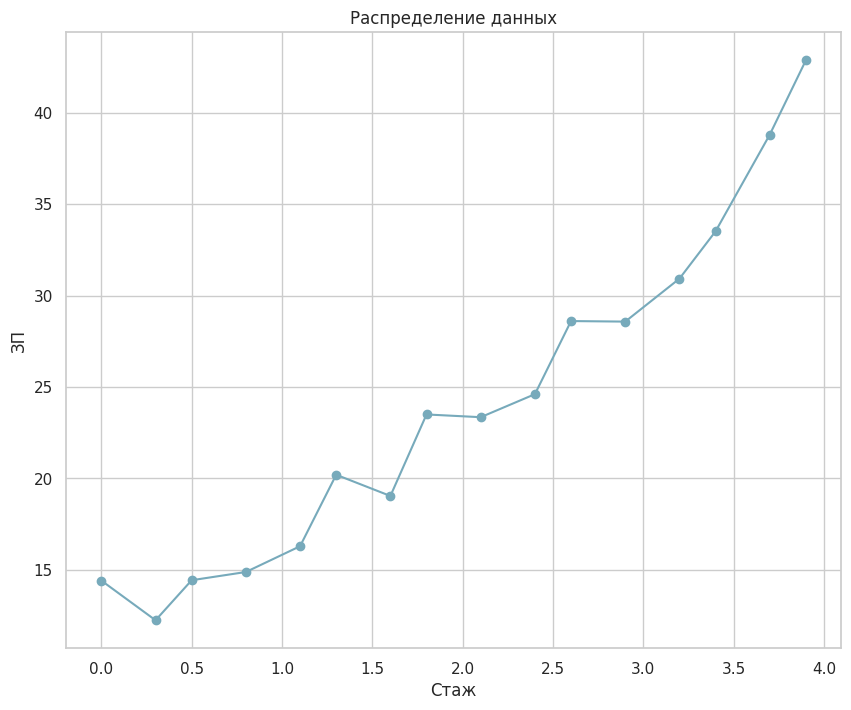

In [489]:
fig, ax = plt.subplots(figsize=(10, 8))
plt.title("Распределение данных")
sns.set_theme(style='whitegrid', palette='blend:#7AB,#EDA')
sns.lineplot(x='Стаж', y='ЗП', data=data_train, markers=True)
plt.scatter(x=data['Стаж'], y=data['ЗП'])
plt.show()

In [470]:
X = data_train['Стаж']
y = data_train['ЗП']

In [490]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

In [491]:
def get_mae(data_pred: np.array, data_test: pd.Series) -> None:
    """
    Функция для рассчета mean absolute error
    :param data_pred: предсказанные данные
    :param data_test: реальные данные
    :return: mean absolute error
    """
    model_mae = round(mean_absolute_error(data_pred, data_test), 2)
    print(f'MAE: {model_mae}')
    print(f'Отношение среднего числа к ошибки: {round(y.mean() / model_mae, 2)}')
    
def prediction_chart(model, final_model=False) -> None:
    """
    Функция для отрисовки предсказанного графика относительно реального
    :param model: обученная модель
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(model.__class__.__name__)
    sns.set_theme(style='whitegrid', palette='blend:#7AB,#EDA')
    sns.lineplot(x='Стаж', y='ЗП', data=data_train, markers=True, label='true', c='green')
    y_pred = model.predict(X[:, np.newaxis])
    x = data_train['Стаж']
    if final_model:
        y_pred = model.predict(data['Стаж'][:, np.newaxis])
        x = data['Стаж']
    sns.lineplot(x=x, y=y_pred, markers=True, label='pred', c='red')
    plt.scatter(x=data['Стаж'], y=data['ЗП'])
    plt.show()

<br>
<font size=4>LinearRegression</font><br>
<br>

In [492]:
linreg = LinearRegression()

linreg.fit(X_train[:, np.newaxis], y_train)
pred = linreg.predict(X_test[:, np.newaxis])
get_mae(pred, y_test)

MAE: 2.44
Отношение среднего числа к ошибки: 9.89


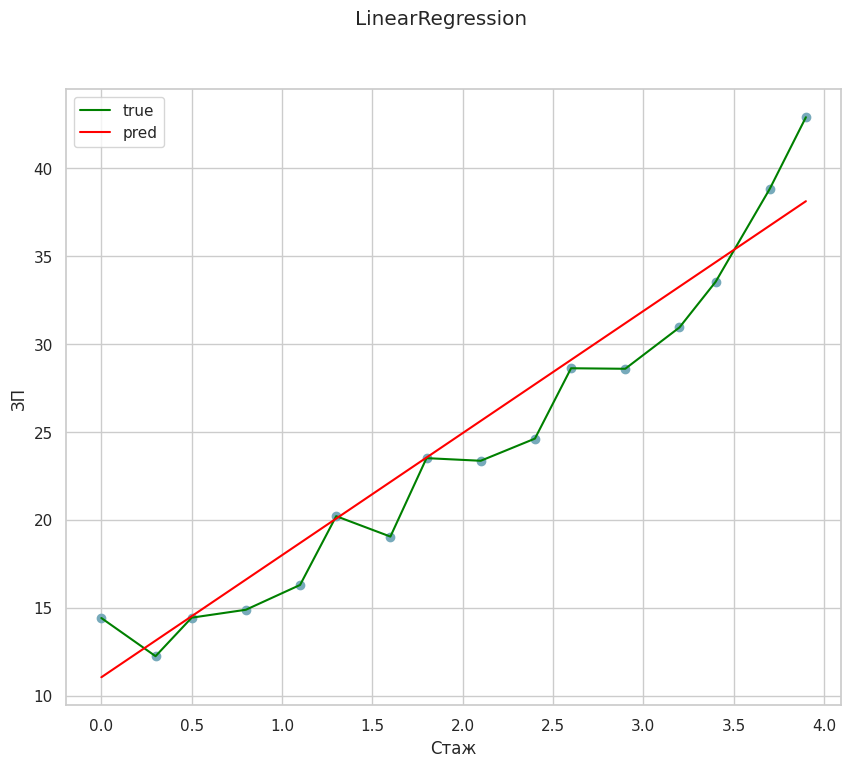

In [493]:
prediction_chart(model=linreg)

<br>
<font size=4>DecisionTreeRegressor</font><br>
<br>

In [494]:
tree = DecisionTreeRegressor(max_depth=5)

tree.fit(X_train[:, np.newaxis], y_train)
pred = tree.predict(X_test[:, np.newaxis])
get_mae(pred, y_test)

MAE: 4.06
Отношение среднего числа к ошибки: 5.95


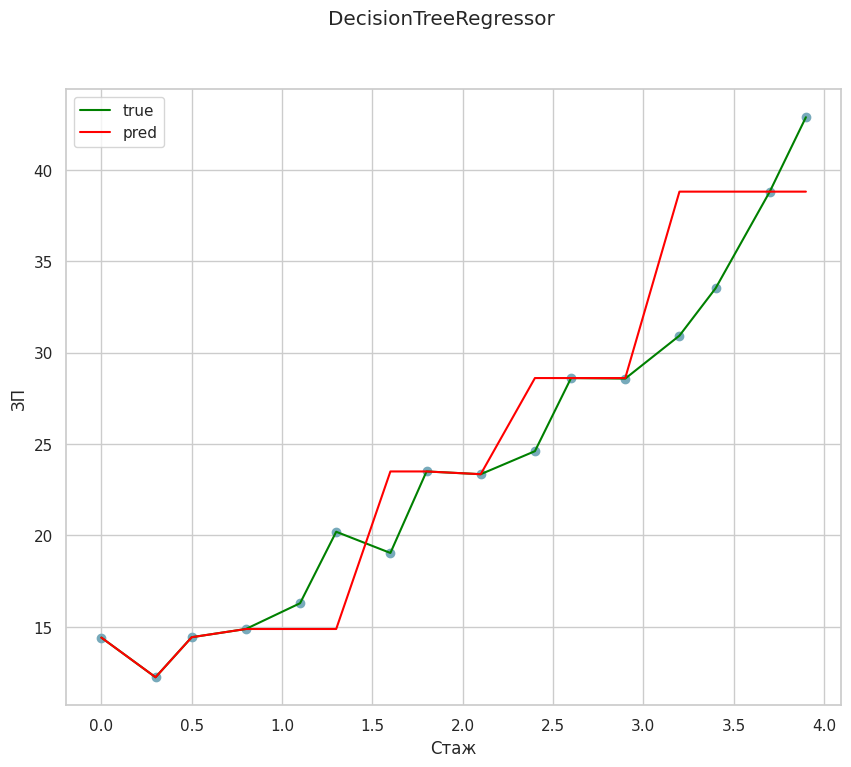

In [495]:
prediction_chart(model=tree)

<br>
<font size=4>KNeighborsRegressor</font><br>
<br>

In [496]:
knn = KNeighborsRegressor(n_neighbors=2)

knn.fit(X_train[:, np.newaxis], y_train)
pred = knn.predict(X_test[:, np.newaxis])
get_mae(pred, y_test)

MAE: 2.89
Отношение среднего числа к ошибки: 8.35


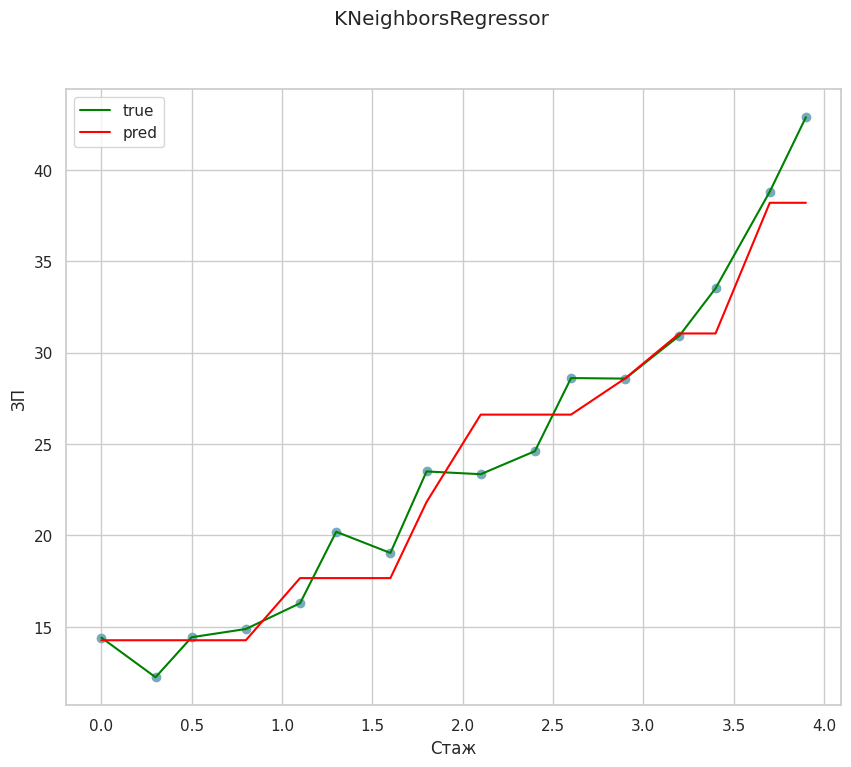

In [478]:
prediction_chart(model=knn)

<br>
Линейная Регрессия показывает лучший результат, поэтому для предсказания будем использовать ее<br>
<br>

In [482]:
X_pred = data_test['Стаж']

lingreg = LinearRegression()
lingreg.fit(X[:, np.newaxis], y)
pred = linreg.predict(X_pred[:, np.newaxis])
pred

array([47.58035204])

<br>
<font size=4>Ответ к задаче:</font>
<br><br>

In [483]:
data.iloc[16, 1] = pred
data

,Стаж,ЗП
0,0.0,14.410000
1,0.3,12.240000
2,0.5,14.430000
3,0.8,14.880000
4,1.1,16.290000
5,1.3,20.200000
6,1.6,19.040000
7,1.8,23.500000
8,2.1,23.350000
9,2.4,24.610000


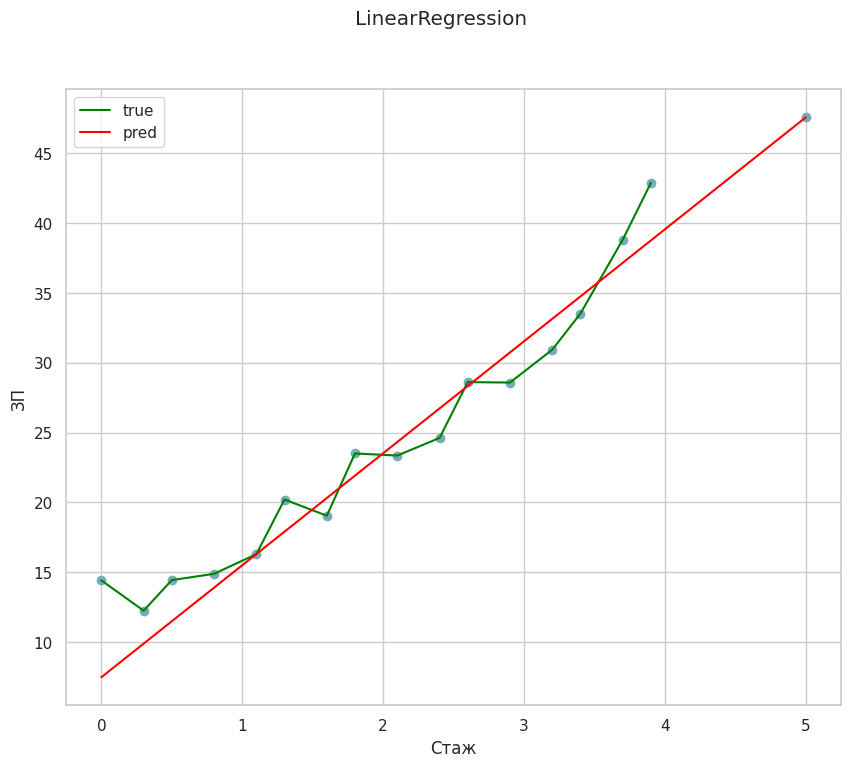

In [484]:
prediction_chart(model=linreg, final_model=True)

In [485]:
data.to_excel('salary.xlsx')